In [1]:
from graph_tool.all import *
from numpy.random import randint
from numpy.random import random
from numpy.random import *
from IPython.display import Image #import to displaz images
from matplotlib import *
from gi.repository import Gtk, Gdk, GdkPixbuf, GObject, GLib
import sys, os, os.path
import time
import numpy as np
import matplotlib.pyplot as plt
#things to be done, figure out all the movement and movement in between states
#add different infection probabilities for vaccination and age group
#if person is vaccinated and not vaccinated


In [2]:
g = Graph(directed=False)

#definition of vertex properties
S = [1, 1, 1, 1]           # White color

I = [0, 0, 0, 1]           # Black color

R = [0.5, 0.5, 0.5, 1.]    # Grey color (will not actually be drawn)

V = [0, 0, 1, 1]           # Blue color

D = [0.8, 0, 0, 0.6]       #DEATH (red)

tlist = list()

for i in range(20):
    tlist.append(i+1)
    
sval=list()

ival=list()
rval=list()
vval=list()
dval=list()
scount=0
icount=0
vcount=0
rcount=0
dcount=0
ccount=0

#all definitions of vertice edges
state = g.new_vertex_property("vector<double>")
age=g.new_vertex_property("int")
vac=g.new_vertex_property("bool")
removed = g.new_vertex_property("bool")
newly_infected = g.new_vertex_property("bool")


agegroups=20
agegrouplists = [[] for i in range(1, agegroups+1)]

#creation of age buckets
for v in g.vertices():
    i=randint(1,age_groups)
    vprop_age[v] = i
    
    

    
#probabilities
x = 0  # spontaneous outbreak probability

r = 0.1      # I->R probability
vac_r = 0.8  # I->R probability if vaccinated
vac_prob = 0.2 #probability to SPAWN vaccinated
s = 0    # R->S probability

#death probability list for different age groups
drlist = [0,0,0,0,0,0,0,0,0,0,0,0,.10,.20,.30,.40,.50,.60,.90,1]
#infection probability for different age groups
inflist = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

#[.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.40,.50,.60,.90,1]
vac_drlist = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.10]

vac_inflist = [.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.30,.40,.50,.60,.90,1]
#[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.10]

In [3]:
#for i in range(0,agegroups):
 #   print(i+1,': ',len(agegrouplists[i]))

In [4]:
#print(agegrouplists)

In [5]:
ages = np.genfromtxt('Age_Dists/JapanDist.csv', delimiter=',')[:,1]
#print(ages)

In [6]:
def add_ages(g,distribution):
    path1 = 'Age_Dists/'
    path2 = 'Dist.csv'
    #generate array containing amount of people per age group
    agedistribution = np.genfromtxt(path1+distribution+path2, delimiter=',')[:,1]
    #visit vertices in random order
    
    vs = list(g.vertices())
    shuffle(vs)
    #we will fill all age groups one by one
    a = 1 #current agegroup
    counter = 0 #counter for how many people have been placed in current group
    
    for v in vs:
        if(a > 20):
            #safety measure
            return
        if counter < agedistribution[a-1]:
            #if current age group hasn't gotten enough people assigned, add another, move on to next vertix
            age[v] = a
            agegrouplists[a].append(v)
            counter = counter + 1
        else:
            #current age group is full, move to next age group with at least one person
            a = a + 1
            while(agedistribution[a-1] == 0):
                if(a < 20):
                    a = a + 1
                else:
                    #in case number for last age group is 0
                    return
            age[v] = a
            agegrouplists[a].append(v)
            counter = 1

In [7]:
#Creation of graph
#insert random vertices (nodes)
g.add_vertex(100)

# insert some random links
for s,t in zip(randint(0, 100, 100), randint(0, 100, 100)):
    g.add_edge(g.vertex(s), g.vertex(t))
# layout positions
pos = sfdp_layout(g)
global scount
global vcount
#makes all nodes suceptible
for i in g.vertices():
    v = g.vertex(i) 
    
    state[v] = S
    scount+=1
    vac[v]=False;
    
    if random() < vac_prob:
    
        vac[v]=True;
        vcount+=1
        scount-=1
        state[v] = V

#this line is to randomlyinitialize one vertex as infected
state[randint(0,100)]= I

'''#gives all nodes an age and then adds nodes to an age group list
for i in g.vertices():
    v = g.vertex(i)
    a =randint(1,agegroups)
    age[v] = a
    agegrouplists[a].append(v)
'''
add_ages(g,'Japan')

#current placeholder for adding vaccination properties
if 1 == 2:
    for i in g.vertices():
        v = g.vertex(i)
        vac[v] = False

        
#Displaying how the graph will be initialized
graph_draw(g, vertex_text=g.vertex_index, output="two-nodes.png")
fig = Image(filename=('two-nodes.png'))
fig


# If True, the frames will be dumped to disk as images.
# CAN SOMONE FIGURE OUT WHAT THIS DOES???????????????????????????????
#if the argument passed from command line=="offscreen" then do the thing else false

offscreen = sys.argv[1] == "offscreen" if len(sys.argv) > 1 else False

max_count = 500

if offscreen and not os.path.exists("./frames"):

    os.mkdir("./frames")
#?????????????????????????????????????????????????????????????????????


# This creates a GTK+ window with the initial graph layout,basically creates the pop up window

if not offscreen:

    win = GraphWindow(g, pos, geometry=(500, 400),
                      

                      edge_color=[0.6, 0.6, 0.6, 1],

                      vertex_fill_color=state,

                      vertex_halo=newly_infected,

                      vertex_halo_color=[0.8, 0, 0, 0.6],)

else:

    count = 0

    win = Gtk.OffscreenWindow()

    win.set_default_size(500, 400)

    win.graph = GraphWidget(g, pos,
                            
                            edge_color=[0.6, 0.6, 0.6, 1],

                            vertex_fill_color=state,
                            
                            vertex_halo=newly_infected,

                            vertex_halo_color=[0.8, 0, 0, 0.6])

    win.add(win.graph)

In [8]:
#drlist[age[10]]

In [9]:
def update_state():
    global sval
    global ival
    global rval
    global vval
    global dval
    global scount
    global icount
    global vcount
    global rcount
    global dcount
    global ccount
    global tlist
    newly_infected.a = False

    removed.a = False
    
    if ccount==20:
        plt.plot(tlist, sval, label = "S")
        plt.plot(tlist, rval, label = "R")
        plt.plot(tlist, vval, label = "V")
        plt.plot(tlist, ival, label = "I")
        plt.plot(tlist, dval, label = "D")
        plt.legend()
        plt.show()
        
        
    # visit the nodes in random order
    ccount+=1

    vs = list(g.vertices())

    shuffle(vs)

    for v in vs:

        if state[v] == I:
            
            if vac[v]==False and random() < r : #r: recovery rate
                rcount+=1
                icount-=1
                state[v] = R
                
            elif vac[v] == True and random() < vac_r:
                rcount+=1
                icount-=1
                state[v] = R
                
            if vac[v] == False and random() < drlist[age[v]]:
            
                state[v] = D       #dead
                dcount+=1
                icount-=1
                g.clear_vertex(v)  # red circle with no adjacent edges
                
            elif vac[v] == True and random() < vac_drlist[age[v]]:
            
                state[v] = D       #vac dead
                dcount+=1
                icount-=1
                g.clear_vertex(v)  # red circle with no adjacent edges

        elif state[v] == S or state[v] == V:

            if random() < x: #x: spontaneous infection rate -> do we reallz need this not really?

                state[v] = I

            else:

                ns = list(v.out_neighbors())

                if len(ns) > 0:

                    w = ns[randint(0, len(ns))]  # choose a random neighbor

                    if state[w] == I:
                        
                        #added infection rate depending on age
                        if state[v] == S:
                            
                            if random()<inflist[age[v]]:
                                
                                state[v] = I
                                icount+=1
                                scount-=1
                                newly_infected[v] = True
                                
                        elif state[v] == V:
                            
                            if random()<vac_inflist[age[v]]:
                                icount+=1
                                #scount-=1
                                state[v] = I
                                
                                newly_infected[v] = True
                        
            # add transition to new state V - vaccinated, right now they spawn vaccinated

       #elif random() < s: #what is this supposed to be?

       #    state[v] = S

        if state[v] == R:
        
            removed[v] = True
       
    ival.append(icount)
    vval.append(vcount)
    sval.append(scount)
    rval.append(rcount)
    dval.append(dcount)
    
    # Filter out the recovered vertices

    g.set_vertex_filter(removed, inverted=True)


    # The following will force the re-drawing of the graph, and issue a

    # re-drawing of the GTK window.

    win.graph.regenerate_surface()
    time.sleep(0.2)
    win.graph.queue_draw()


    # if doing an offscreen animation, dump frame to disk

    if offscreen:

        global count

        pixbuf = win.get_pixbuf()

        pixbuf.savev(r'./frames/sirs%06d.png' % count, 'png', [], [])

        if count > max_count:

            sys.exit(0)

        count += 1


    # We need to return True so that the main loop will call this function more

    # than once.

    return True


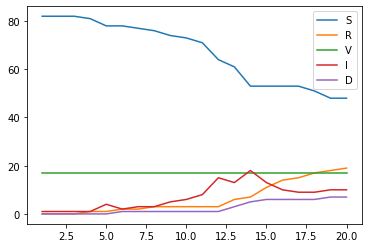

In [ ]:
cid = GLib.idle_add(update_state)


# We will give the user the ability to stop the program by closing the window.

win.connect("delete_event", Gtk.main_quit)


# Actually show the window, and start the main loop.

win.show_all()

Gtk.main()

In [ ]:
g.list_properties()

In [ ]:
g.save("my_graph.xml.gz")
g2 = load_graph("my_graph.xml.gz")